## Sequence Classification with IMDb Reviews


In [ ]:
!nvidia-smi

In [ ]:
!pip install transformers

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2021-05-07 11:32:29--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  13.9MB/s    in 8.3s    

2021-05-07 11:32:38 (9.64 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



### loading train and test data

In [ ]:
from pathlib import Path

# reading imdb reviews
def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')

### seperating validation data from train data

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

### DistilBert Tokenizer

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

### Tokenizing IMDB data

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

### Converting labels and encodings to "Dataset" objects 

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

## Fine Tuning


1.   Using Trainer Class provided by 🤗Huggingface
2.   Or using Tensorflow/Pytorch
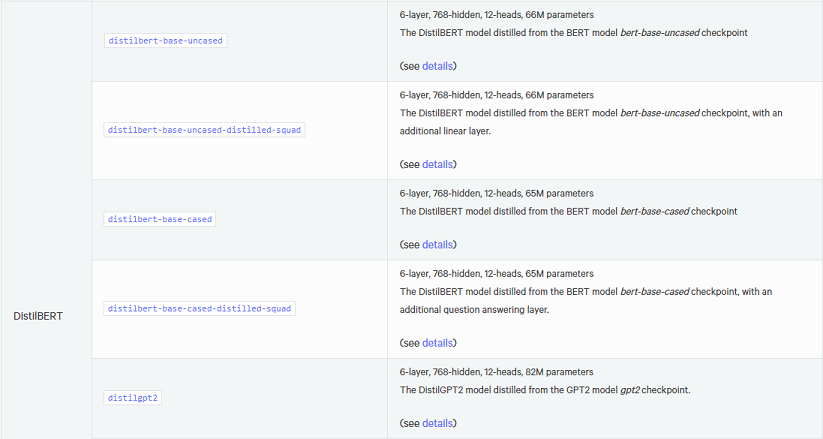

### Trainer

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased") #load model

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

### Tensorflow/Pytorch method

#### Pytorch

In [ ]:
#PyTorch

# from torch.utils.data import DataLoader
# from transformers import DistilBertForSequenceClassification, AdamW

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
# model.to(device)
# model.train()

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# optim = AdamW(model.parameters(), lr=5e-5)

# for epoch in range(3):
#     for batch in train_loader:
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

# model.eval()

#### Tensorflow

In [ ]:
# Tensorflow

from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss) # can also use any keras loss fn
model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
1250/1250 [==============================] - 2209s 2s/step - loss: 0.3293
Epoch 2/3
1250/1250 [==============================] - 2211s 2s/step - loss: 0.1540
Epoch 3/3
1250/1250 [==============================] - 2211s 2s/step - loss: 0.0762


### Inference

In [ ]:
def predict_text(text):
  inputs = tokenizer(text, return_tensors="tf")
  inputs["labels"] = tf.reshape(tf.constant(1), (-1, 1)) # Batch size 1
  outputs = model(inputs)
  if outputs.logits.numpy()[0][0] < outputs.logits.numpy()[0][1]:
    return "Positive : 1"
  else:
    return "Negative : 0"

In [ ]:
for i in [1,100,21000,21520]:
  print(test_texts[i])
  print(predict_text(test_texts[i]))
  print("should be {}".format(test_labels[i]))
  print()

I was very curious to see this Wajda-Depardieu outing, plus the time period is definitely fascinating. Being a Wajda fan, I was disappointed, and that may be an understatement. The film never really took cinematic flight -- there's no foundation for the animosity between Danton and Robespierre, etc.<br /><br />Basically, the script was weak (adapted from "The Danton Affair"). And yet, the direction was masterful...it's Wajda, afterall! Also, there were some amazing actors BUT they never really grab the audience's attention like they should. Depardieu comes off as a quasi-goofy, nonchalant Danton...not exactly the image we have in mind. Woijech Pzsoniak is incredible, as usual, but again the script puts up limits even actors of great talent can't break down. Andrzej Seweryn and Bogoslaw Linda pop up ... as Bourdon and Saint-Just...and if you're familiar with Wajda, then you'd know them.<br /><br />Overall, I was disappointed with this much-lauded film. Great cast, great director, but no